In [1200]:
import math

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import torchvision.utils as vutils
from sklearn.preprocessing import LabelEncoder
from torch import optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from skimage import io,transform
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage, RandomCrop

%matplotlib inline
import matplotlib.pyplot as plt

In [1201]:
le = LabelEncoder()

In [1202]:
def encode_dataframe(df):
    df[4] = df[1].astype(str) + "," + df[2].astype(str) +","+ df[3].astype(str)
    df[4]  = le.fit_transform(df[4])
    return df

In [1203]:
class FaceDataset(Dataset):
    """Custom Fashion MNIST dataset."""

    def __init__(self, csv_file, image_dir,transform):
        self.labels_df = pd.read_csv(csv_file,header=None)
        self.labels_df = encode_dataframe(self.labels_df)
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.labels_df.iloc[idx, 0])
        image = Image.open(img_name)
        image = self.transform(image)
        camera_position = torch.tensor(self.labels_df.iloc[idx, 4])
        camera_position =  camera_position.type(torch.LongTensor)





        return image, camera_position,img_name

In [1204]:
# Define some parameters
batch_size = 8
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 8 # Size of feature maps in generator
ndf = 8 # Size of feature maps in discriminator
num_epochs = 10 # Number of training epochs
lr = 0.001 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers



In [1205]:
train_dataset = FaceDataset(csv_file='deeplearning/train/labels.csv',
                            image_dir='deeplearning/train',transform=transforms.Compose([transforms.Resize(160),
                                                                                            transforms.ToTensor(),transforms.Normalize(0.5,0.5),]))

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

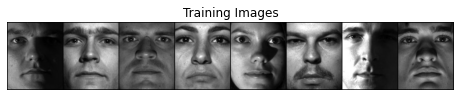

In [1206]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [1207]:
def get_output_size(input_size,kernel_size,stride,padding):
    return (input_size-1)*stride - 2*padding + (kernel_size-1)+1

In [1208]:
get_output_size(10,4,2,1)

20

In [1209]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( in_channels=nz, out_channels= ngf * 128, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 128),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels=ngf * 128,out_channels=ngf * 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 64),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( in_channels=ngf * 64, out_channels=ngf * 32, kernel_size=5, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            # state size. (ngf*2) x 10 x 10
            nn.ConvTranspose2d( in_channels=ngf * 32, out_channels=ngf*16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*16),
            nn.ReLU(True),
            # state size. (ngf*2) x 2
            # state size. (ngf*2) x 40 x 40
            nn.ConvTranspose2d( in_channels=ngf * 16, out_channels=ngf*4, kernel_size=4, stride=4, padding=0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*2) x80 x 180
            nn.ConvTranspose2d( in_channels=ngf*4, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),

            nn.Tanh()
            # state size. (ngf) x 160 x 160
        )

    def forward(self, input):
        return self.main(input)

netG = Generator()
netG = netG.to(device)

In [1210]:
z = torch.randn(8,100,1,1).to("cuda")

In [1211]:
netG(z).shape

torch.Size([8, 1, 160, 160])

In [1212]:
class Discriminator(nn.Module):
    def __init__(self, ):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 160 x 160
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 80 x 80
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 40 x 40
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 20 x 20
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 10 x 10
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 4, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator()
netD = netD.to(device)

In [1213]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(8, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
#optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.SGD(netD.parameters(),lr=lr)
optimizerG = optim.SGD(netG.parameters(),lr=lr)

In [1214]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/230]	Loss_D: 1.7693	Loss_G: 0.6278	D(x): 0.6255	D(G(z)): 0.7228 / 0.5349
[0/10][50/230]	Loss_D: 0.6913	Loss_G: 1.5079	D(x): 0.7604	D(G(z)): 0.3344 / 0.2234
[0/10][100/230]	Loss_D: 0.3460	Loss_G: 2.1476	D(x): 0.8750	D(G(z)): 0.1904 / 0.1172
[0/10][150/230]	Loss_D: 0.1944	Loss_G: 2.6250	D(x): 0.9198	D(G(z)): 0.1034 / 0.0727
[0/10][200/230]	Loss_D: 0.0932	Loss_G: 3.0612	D(x): 0.9751	D(G(z)): 0.0656 / 0.0473
[1/10][0/230]	Loss_D: 0.0465	Loss_G: 3.6159	D(x): 0.9869	D(G(z)): 0.0327 / 0.0272
[1/10][50/230]	Loss_D: 0.0322	Loss_G: 3.9921	D(x): 0.9892	D(G(z)): 0.0211 / 0.0186
[1/10][100/230]	Loss_D: 0.0362	Loss_G: 4.1610	D(x): 0.9815	D(G(z)): 0.0174 / 0.0158
[1/10][150/230]	Loss_D: 0.0247	Loss_G: 4.1639	D(x): 0.9930	D(G(z)): 0.0175 / 0.0156
[1/10][200/230]	Loss_D: 0.0227	Loss_G: 4.2839	D(x): 0.9929	D(G(z)): 0.0154 / 0.0139
[2/10][0/230]	Loss_D: 0.0212	Loss_G: 4.1112	D(x): 0.9974	D(G(z)): 0.0185 / 0.0165
[2/10][50/230]	Loss_D: 0.0157	Loss_G: 4.5792	D(x): 0.9960	

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generation of 8 Faces

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Interpolation of 7 Faces

In [ ]:
# Solution

nsamples = 7
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z = torch.zeros(nsamples,nz,1,1,device=device)
for i in range(nsamples):
    w1 = i/(nsamples-1)
    w2 = 1-w1
    z[i,:,:,:] = w1*z1 + w2*z2
images = netG(z)

figure = plt.figure(figsize=(12, 4))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i+1)
    plt.axis("off")
    plt.imshow(0.5-0.5*images[i,:].squeeze().cpu().detach(), cmap="gray")
plt.show()
